# EDA for CHGH dataset

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Setup Environment

In [2]:
# mount driver
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CardiacSeg/eda/CHGH

# install dependents
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

# sync python module
%load_ext autoreload
%autoreload 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1jz_DGnICBmKWCr_JL904PDQdIEK0_EQG/CardiacSeg/eda/CHGH


## Import Library

In [3]:
import sys
# set package path
sys.path.append("/content/drive/MyDrive/CardiacSeg")

from monai.data import CacheDataset, DatasetSummary
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord
)
from monai.utils import first

import matplotlib.pyplot as plt
import pandas as pd

from data_utils.chgh_dataset import get_data_dicts
from data_utils.visualization import show_img_lbl
from data_utils.utils import get_data_info

## Prepare data dicts

In [4]:
data_dir = '/content/drive/MyDrive/CardiacSeg/dataset/CHGH/dataset'

In [5]:
data_dicts = get_data_dicts(data_dir)

## Show data info

pid: pid_08
file_pth: /content/drive/MyDrive/CardiacSeg/dataset/CHGH/dataset/pid_08/pid_08.nii.gz
img shape: [512, 512, 341]
img spacing: [0.38085938, 0.38085938, 0.5]
lbl shape: [512, 512, 341]
lbl spacing: [0.38085938, 0.38085938, 0.5]
lbl ids: [0. 1.]


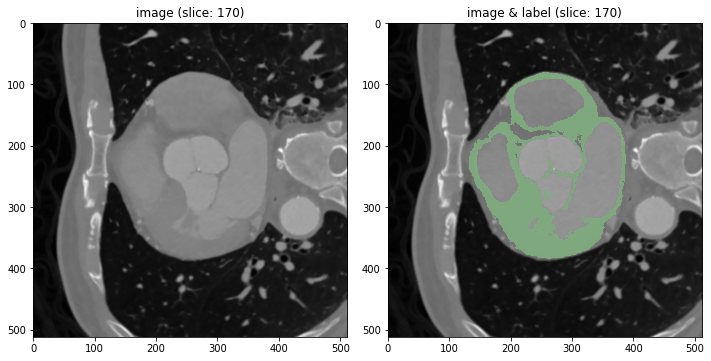


pid: pid_34
file_pth: /content/drive/MyDrive/CardiacSeg/dataset/CHGH/dataset/pid_34/pid_34.nii.gz
img shape: [512, 512, 308]
img spacing: [0.33398438, 0.33398438, 0.5]
lbl shape: [512, 512, 308]
lbl spacing: [0.33398438, 0.33398438, 0.5]
lbl ids: [0. 1.]


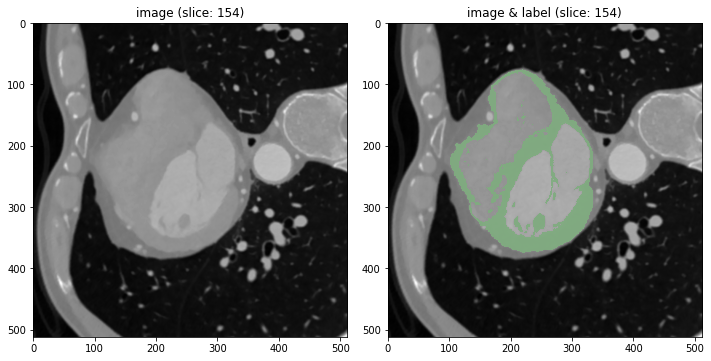


pid: pid_106
file_pth: /content/drive/MyDrive/CardiacSeg/dataset/CHGH/dataset/pid_106/pid_106.nii.gz
img shape: [512, 512, 403]
img spacing: [0.42382812, 0.42382812, 0.4]
lbl shape: [512, 512, 403]
lbl spacing: [0.42382812, 0.42382812, 0.4]
lbl ids: [0. 1.]


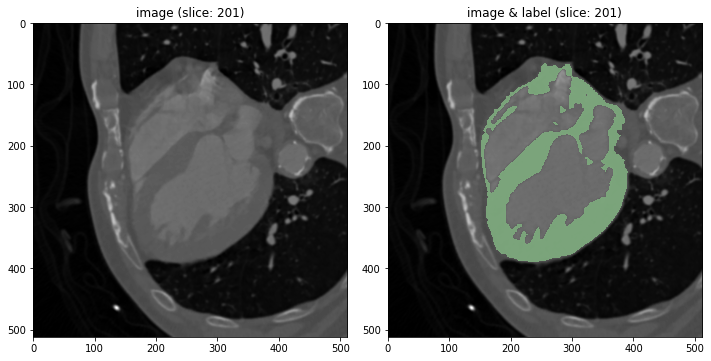


pid: pid_107
file_pth: /content/drive/MyDrive/CardiacSeg/dataset/CHGH/dataset/pid_107/pid_107.nii.gz
img shape: [512, 512, 376]
img spacing: [0.33203125, 0.33203125, 0.4]
lbl shape: [512, 512, 376]
lbl spacing: [0.33203125, 0.33203125, 0.4]
lbl ids: [0. 1.]


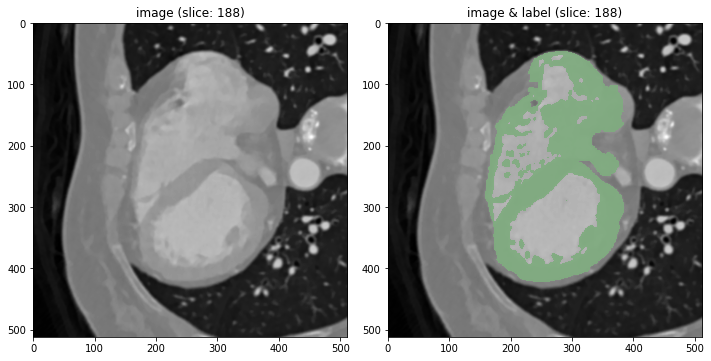


pid: pid_108
file_pth: /content/drive/MyDrive/CardiacSeg/dataset/CHGH/dataset/pid_108/pid_108.nii.gz
img shape: [512, 512, 267]
img spacing: [0.3359375, 0.3359375, 0.5]
lbl shape: [512, 512, 267]
lbl spacing: [0.3359375, 0.3359375, 0.5]
lbl ids: [0. 1.]


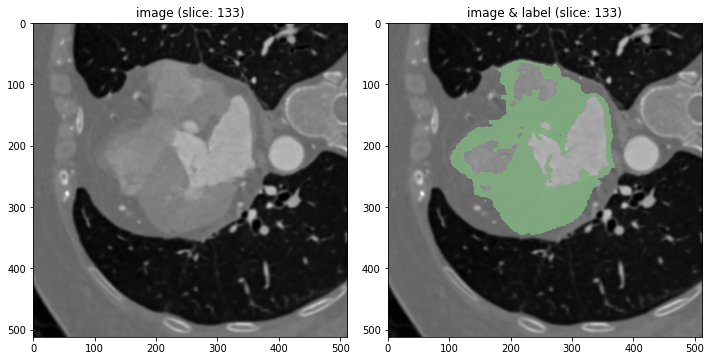


pid: pid_110
file_pth: /content/drive/MyDrive/CardiacSeg/dataset/CHGH/dataset/pid_110/pid_110.nii.gz
img shape: [512, 512, 366]
img spacing: [0.37890625, 0.37890625, 0.4]
lbl shape: [512, 512, 366]
lbl spacing: [0.37890625, 0.37890625, 0.4]
lbl ids: [0. 1.]


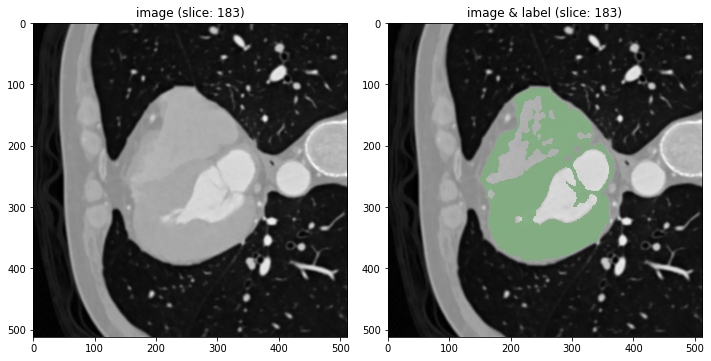

In [13]:
data_info_df = get_data_info(data_dicts)

In [14]:
data_info_df

,pid,img_shape,img_space,lbl_shape,lbl_space,lbl_ids
0,pid_08,"[512, 512, 341]","[0.38085938, 0.38085938, 0.5]","[512, 512, 341]","[0.38085938, 0.38085938, 0.5]","[0.0, 1.0]"
1,pid_34,"[512, 512, 308]","[0.33398438, 0.33398438, 0.5]","[512, 512, 308]","[0.33398438, 0.33398438, 0.5]","[0.0, 1.0]"
2,pid_106,"[512, 512, 403]","[0.42382812, 0.42382812, 0.4]","[512, 512, 403]","[0.42382812, 0.42382812, 0.4]","[0.0, 1.0]"
3,pid_107,"[512, 512, 376]","[0.33203125, 0.33203125, 0.4]","[512, 512, 376]","[0.33203125, 0.33203125, 0.4]","[0.0, 1.0]"
4,pid_108,"[512, 512, 267]","[0.3359375, 0.3359375, 0.5]","[512, 512, 267]","[0.3359375, 0.3359375, 0.5]","[0.0, 1.0]"
5,pid_110,"[512, 512, 366]","[0.37890625, 0.37890625, 0.4]","[512, 512, 366]","[0.37890625, 0.37890625, 0.4]","[0.0, 1.0]"


In [15]:
data_shape_df = pd.DataFrame(data_info_df['img_shape'].to_list(), columns=['w', 'h', 's'])
data_shape_df.mean()

w    512.0
h    512.0
s    343.5
dtype: float64

In [16]:
data_space_df = pd.DataFrame(data_info_df['img_space'].to_list(), columns=['x', 'y', 'z'])
data_space_df.mean()

x    0.364258
y    0.364258
z    0.450000
dtype: float32

## Statcics

In [17]:
base_tf = Compose([
    LoadImaged(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label'])
])

ds = CacheDataset(
    data=data_dicts,
    transform=base_tf
)

/usr/local/lib/python3.7/dist-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)
Loading dataset: 100%|██████████| 6/6 [00:38<00:00,  6.46s/it]


In [18]:
# ref: https://arxiv.org/pdf/1904.08128.pdf
s = DatasetSummary(ds)
s.calculate_percentiles()
s.calculate_statistics()
data_target_space = s.get_target_spacing()

In [19]:
print('data target space:')
data_target_space

data target space:


(0.357421875, 0.357421875, 0.45000000298023224)

In [20]:
print('data intensities statcics:')
data_intensities_statcics = pd.DataFrame(
    [[s.data_min, s.data_median, s.data_max, s.data_mean, s.data_std, s.data_min_percentile, s.data_max_percentile]],
    columns=['min', 'med', 'max', 'mean', 'std', 'min_percentile (0.5%)', 'max_percentile (99.5%)']
)
data_intensities_statcics

data intensities statcics:


,min,med,max,mean,std,min_percentile (0.5%),max_percentile (99.5%)
0,-679.0,103.0,821.0,115.816994,71.320045,-44.0,351.0


## Resample

In [ ]:
ratio_w_s = ((data_shape_df['w'] * data_space_df['x']) / (data_shape_df['s'] * data_space_df['z'])).mean()
ratio_w_s

1.3554126

In [ ]:
re_s_pix_dim = 0.77 #((data_shape_df['s'] * data_space_df['z'])/192).mean()
re_w_pix_dim = ratio_w_s * re_s_pix_dim
print('re_w_pix_dim:', re_w_pix_dim)
print('re_s_pix_dim:', re_s_pix_dim)

re_w_pix_dim: 1.0436677038669586
re_s_pix_dim: 0.77


In [ ]:
print('resample width:')
data_re_w = (data_shape_df['w'] * data_space_df['x']) / re_w_pix_dim
data_re_w

resample width:


0    195.556854
1    193.779068
2    173.334488
3    185.779022
4    168.001129
5    168.001129
6    192.890182
7    151.112122
8    152.889908
dtype: float32

In [ ]:
print('resample slice:')
data_re_s = (data_shape_df['s'] * data_space_df['z']) / re_s_pix_dim
data_re_s

resample slice:


0    197.402603
1    233.116882
2    221.428574
3    204.545456
4    148.701309
5    148.701309
6    209.349365
7    195.324692
8    173.376633
dtype: float32

In [ ]:
(data_re_w / data_re_s)

0    0.990650
1    0.831253
2    0.782801
3    0.908253
4    1.129789
5    1.129789
6    0.921379
7    0.773646
8    0.881837
dtype: float32

## Transform

In [ ]:
from data_utils.chgh_dataset import get_loader
import argparse
parser = argparse.ArgumentParser(description="model segmentation pipeline")
parser = argparse.ArgumentParser(description="model segmentation pipeline")
# mode
parser.add_argument("--test_mode", action="store_true", help="test mode")

# dir and path
parser.add_argument("--data_dir", default="", type=str, help="dataset directory")
parser.add_argument("--model_dir", default="models", type=str, help="directory to save the models")
parser.add_argument("--log_dir", default="logs", type=str, help="directory to save the tensorboard logs")
parser.add_argument("--eval_dir", default="evals", type=str, help="directory to save the eval result")
parser.add_argument("--checkpoint", default=None, help="start training from saved checkpoint")
parser.add_argument("--filename", default="best_model.pth", help="save model file name")

# train loop
parser.add_argument("--start_epoch", default=0, type=int, help="start epoch")
parser.add_argument("--val_every", default=20, type=int, help="validation frequency")
parser.add_argument("--max_epoch", default=2000, type=int, help="max number of training epochs")

# data
parser.add_argument("--fold", default=4, type=int, help="index of fold")
parser.add_argument("--split_train_ratio", default=0.8, type=float, help="split train ratio")
parser.add_argument("--num_fold", default=5, type=float, help="num fold")
parser.add_argument("--num_samples", default=2, type=int, help="number of samples")
parser.add_argument("--batch_size", default=1, type=int, help="number of batch size")
parser.add_argument("--pin_memory", action="store_true", help="pin memory")
parser.add_argument("--workers", default=2, type=int, help="number of workers")

# model
parser.add_argument("--in_channels", default=1, type=int, help="number of input channels")
parser.add_argument("--out_channels", default=2, type=int, help="number of output channels")

# optimizer
parser.add_argument("--optim_lr", default=1e-4, type=float, help="optimization learning rate")
parser.add_argument("--reg_weight", default=1e-5, type=float, help="regularization weight")

# scheduler
parser.add_argument("--lrschedule", default="warmup_cosine", type=str, help="type of learning rate scheduler")
parser.add_argument("--warmup_epochs", default=50, type=int, help="number of warmup epochs")
parser.add_argument("--resume_ckpt", action="store_true", help="resume training from pretrained checkpoint")

# infer
parser.add_argument("--sw_batch_size", default=4, type=int, help="number of sliding window batch size")
parser.add_argument("--infer_overlap", default=0.25, type=float, help="sliding window inference overlap")

# args
args, unknown = parser.parse_known_args()

# setup config
model_name = 'base_cv1'
root_dir = '/content/drive/MyDrive/CardiacSeg/UNETCNX/CHGH'

args.data_dir = '/content/drive/MyDrive/CardiacSeg/dataset/CHGH/dataset'
args.fold = 2
args.split_train_ratio = 0.6
args.num_fold = 3
args.start_epoch = 0
args.val_every = 5
args.max_epoch = 10
args.pin_memory = True
args.test_mode = False
# args.checkpoint = os.path.join(args.model_dir, 'best_model.pth')

In [ ]:
loader = get_loader(args)

/usr/local/lib/python3.7/dist-packages/monai/utils/deprecate_utils.py:110: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


fold: 2
train files (4): ['Patient_05', 'Patient_07', 'Patient_08', 'Patient_21']
val files (2): ['Patient_23', 'Patient_24']
test files (3): ['Patient_106', 'Patient_107', 'Patient_108']

load train dataset ...


Loading dataset: 100%|██████████| 4/4 [00:28<00:00,  7.11s/it]



load val dataset ...


Loading dataset: 100%|██████████| 2/2 [00:07<00:00,  3.75s/it]


In [ ]:
tr_data = first(loader[0])

train dataset
img shape: (2, 1, 96, 96, 96)


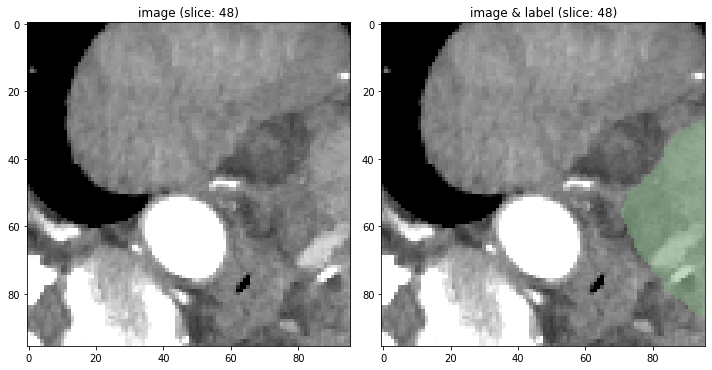

In [ ]:
slice_idx = 48
print('train dataset')
print('img shape:',tr_data['image'].shape)
show_img_lbl(
    tr_data['image'][0,0,:,:,slice_idx],
    tr_data['label'][0,0,:,:,slice_idx],
    slice_idx=slice_idx,
    num_classes=2,
    axis_off=False,
    fig_size=(10,5),
    alpha=0.5
)

In [ ]:
tt_data = first(loader[1])

test dataset
img shape: (1, 1, 190, 190, 149)


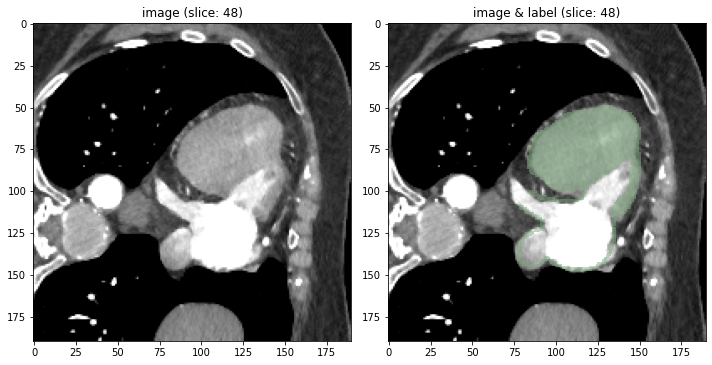

In [ ]:
slice_idx = 48
print('test dataset')
print('img shape:',tt_data['image'].shape)
show_img_lbl(
    tt_data['image'][0,0,:,:,slice_idx],
    tt_data['label'][0,0,:,:,slice_idx],
    slice_idx=slice_idx,
    num_classes=2,
    axis_off=False,
    fig_size=(10,5),
    alpha=0.5
)